# Sea Ice example notebook for timeseries

---

This notebook shows how to use the seaice diagnostic. It contains an example of access of a reference (OSI-SAF or PSC) and model (IFS-NEMO) datasets to evaluate 
and plot the sea ice extension, volume, fraction and thickness variables.

The only import needed is the `SeaIce` and `PlotSeaIce` and `Plot2DSeaIce` classes from the `aqua.diagnostics` module.

In [1]:
from aqua.diagnostics import SeaIce, PlotSeaIce, Plot2DSeaIce

- The `SeaIce` class allow to retrive, regrid and perform the main analysis on the data. It also allow to save the resulting data as NetCDF file (through the method `save_netcdf`). 
- The `PlotSeaIce` class allow to plot and evaluate the `extent` and `volume` of sea ice.
- The `Plot2DSeaIce` class allow to plot 2D maps and evaluate the differences of `fraction` and `thickness` of sea ice.

## Data retrieve and sea ice calculation

At first it must be initialised the class `SeaIce`, which calls internally the `Reader` and performs the regridding (if a `regrid` option is provided).  
Then we compute the sea ice for the model data (using the method `compute_seaice`).  
The `regions` argument allow to choose the specific regions defined by lat-lon in `regions.yaml` file. 

## Seaice extent

### Calculate: model data surface extent 

In [2]:
method   = 'extent'   # This is the method we want to compute with the seaice data
varname  = 'siconc'   # This is the right variable name relative to the desired method for IFS-NEMO
source   = 'lra-r100-monthly' # source name can change depending on the model and exp
regions_domain = ['arctic','antarctic']
regrid='r100'
loglevel = 'info'

seaice_model = SeaIce(model='IFS-NEMO', exp='historical-1990', source=source, regions=regions_domain, 
                      startdate='1991-01-01', enddate='2000-01-01', 
                      regrid=regrid, loglevel='info')
simod = seaice_model.compute_seaice(method=method, var=varname)

2026-01-29 16:16:16 :: ConfigPath :: INFO     -> IFS-NEMO_historical-1990_lra-r100-monthly triplet found in in climatedt-phase1!
2026-01-29 16:16:17 :: FixerConfigure :: INFO     -> Convention dictionary: eccodes-2.39.0
2026-01-29 16:16:17 :: FixerConfigure :: INFO     -> No fixer_name found, only convention will be applied
2026-01-29 16:16:18 :: Reader :: INFO     -> Grid metadata is lon-lat
2026-01-29 16:16:18 :: Regridder :: WARNING  -> Source grid path not found. Please provide a dataset.
2026-01-29 16:16:18 :: Reader :: WARNING  -> Issues in the Regridder() init: trying with data
2026-01-29 16:16:47 :: DataModel :: INFO     -> Applying data model: aqua
2026-01-29 16:16:47 :: CoordIdentifier :: WARNING  -> Coordinate 'level' assigned to multiple types with identical scores: [('depth', 50), ('height', 50)]. Disabling data model check for this coordinate.
2026-01-29 16:16:47 :: CoordTransformer :: INFO     -> Grid type: Regular
2026-01-29 16:16:47 :: CoordTransformer :: INFO     -> T

- The data can be saved into NetCDF files:

In [3]:
seaice_model.save_netcdf(simod, 'seaice', diagnostic_product='timeseries', extra_keys={'method': method, 'source': source, 'regions_domain': "_".join(regions_domain)})

2026-01-29 16:16:51 :: create_folder :: INFO     -> Creating folder ./netcdf
2026-01-29 16:16:51 :: OutputSaver :: INFO     -> Saved NetCDF: ./netcdf/seaice.timeseries.climatedt-phase1.IFS-NEMO.historical-1990.r1.extent.lra-r100-monthly.arctic_antarctic.nc


### Calculate: reference sea ice surface extent 

The same steps must be applied to the observations (reference data). Since we want to plot both the Arctic and Antarctic regions, we need to load the Northern   
and Southern Hemisphere data separately, as OSI-SAF provides these datasets individually. To enable a fairer comparison of model performance against observations,   
the reference sea ice extent standard deviation can be calculated, so set `calc_std_freq='monthly'` to generate the additional datasets with the standard deviation computed from the data.  
At present, only monthly time series plotting is supported for sea ice.  


In [4]:
seaice_ref_nh = SeaIce(model='OSI-SAF', exp='osi-saf-aqua', source='nh-monthly', regions='arctic',
                       startdate='1991-01-01', enddate='2000-01-01', 
                       regrid=regrid, loglevel=loglevel)
si_ref_nh, si_std_ref_nh = seaice_ref_nh.compute_seaice(method=method, var=varname, calc_std_freq='monthly')

seaice_ref_sh = SeaIce(model='OSI-SAF', exp='osi-saf-aqua', source='sh-monthly', regions='antarctic',
                      startdate='1991-01-01', enddate='2000-01-01', 
                      regrid=regrid, loglevel=loglevel)
si_ref_sh, si_std_ref_sh = seaice_ref_sh.compute_seaice(method=method, var=varname, calc_std_freq='monthly')

2026-01-29 16:16:51 :: ConfigPath :: INFO     -> OSI-SAF_osi-saf-aqua_nh-monthly triplet found in in obs!
2026-01-29 16:16:52 :: FixerConfigure :: INFO     -> Convention dictionary: eccodes-2.39.0
2026-01-29 16:16:52 :: FixerConfigure :: INFO     -> Fix names in metadata is OSI-SAF-default
2026-01-29 16:16:52 :: FixerConfigure :: INFO     -> Fix names OSI-SAF-default found in fixes files
2026-01-29 16:16:52 :: Reader :: INFO     -> Grid metadata is osi-saf-nh-aqua
2026-01-29 16:16:52 :: Regridder :: INFO     -> Grid name: osi-saf-nh-aqua
2026-01-29 16:16:52 :: Regridder :: INFO     -> Loading existing source area from /pfs/lustrep3/appl/local/climatedt/data/AQUA/aqua-dvc/areas/cell_area_osi-saf-nh-aqua.nc.
2026-01-29 16:16:52 :: DataModel :: INFO     -> Applying data model: aqua
2026-01-29 16:16:52 :: CoordIdentifier :: WARNING  -> Multiple depth coordinates found with identical scores: [('xc', 50), ('yc', 50)]. Disabling data model check for this coordinate.
2026-01-29 16:16:52 :: Coo

Following example above, the data can be saved in NetCDF.

### Plot: surface extent for reference and model

To plot the seaice timeseries, we first instantiate the `PlotSeaIce` object and then plot it with the `plot_seaice` method.

- The `plot_seaice` method accepts a single xr.DataArray, a xr.Dataset or a list of xr.Dataset.  
Switch *save_pdf* *_png* to *True* to save the figure in the selected *outputdir*:

2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Sea ice data repacked
2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Plotting sea ice timeseries
2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Processing method: extent
2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Processing timeseries for region: Arctic
2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_models
2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_ref
2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_std_ref
2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Processing timeseries for region: Antarctic
2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_models
2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_ref
2026-01-29 16:16:59 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_std_ref
2026-01-29 16:17:00 :: PlotSeaIce :: INFO     -> Plotting of all

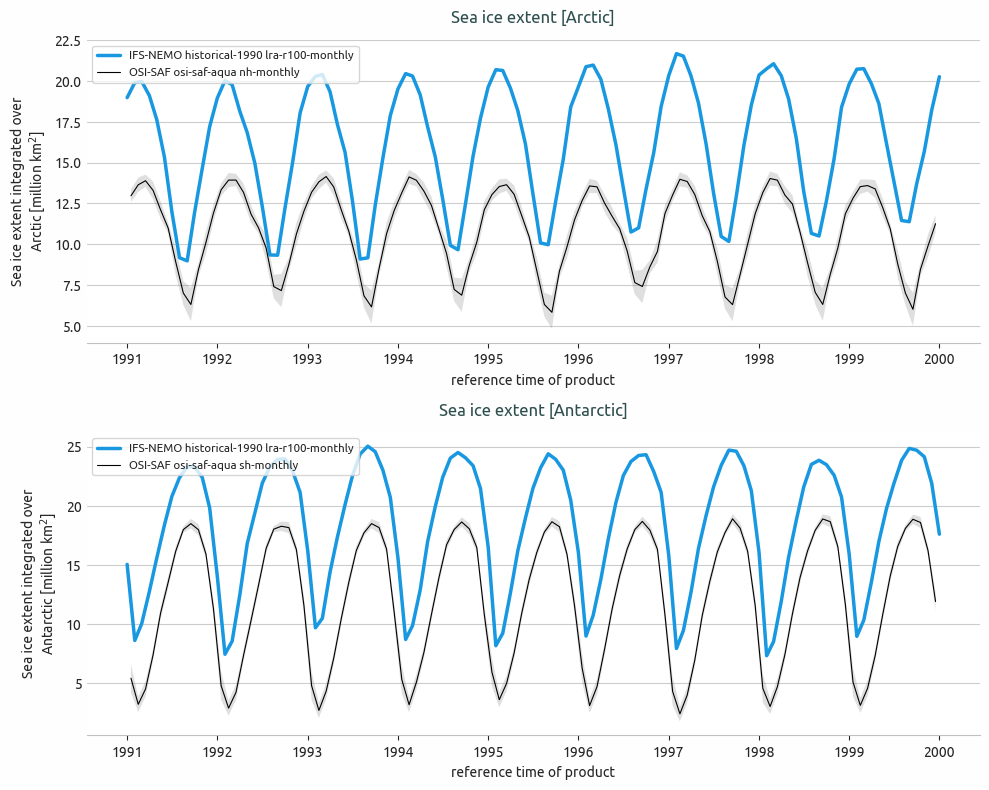

In [5]:
psi = PlotSeaIce(monthly_models=simod,
                 monthly_ref=[si_ref_nh, si_ref_sh],
                 monthly_std_ref=[si_std_ref_nh, si_std_ref_sh], 
                 outputdir='.',
                 rebuild=True,
                 loglevel=loglevel)
psi.plot_seaice(plot_type='timeseries', save_pdf=False, save_png=False)

---

## Seaice volume 

Similar steps as above must be followed for the computation of the integrated volume.

### Calculate: model data sea ice volume

In [6]:
method   = 'volume'    # This is the method we want to compute with the seaice data
varname  = 'sithick'   # This is the right variable name relative to the desired method for IFS-NEMO
source   = 'lra-r100-monthly'
regions_domain = ['arctic','antarctic']
regrid='r100'
loglevel = 'info'

seaice_model = SeaIce(model='IFS-NEMO', exp='historical-1990', source=source, regions=regions_domain,
                      startdate='1991-01-01', enddate='2000-01-01',
                      regrid=regrid, loglevel='info')
simod = seaice_model.compute_seaice(method=method, var=varname)

2026-01-29 16:17:01 :: ConfigPath :: INFO     -> IFS-NEMO_historical-1990_lra-r100-monthly triplet found in in climatedt-phase1!
2026-01-29 16:17:01 :: FixerConfigure :: INFO     -> Convention dictionary: eccodes-2.39.0
2026-01-29 16:17:01 :: FixerConfigure :: INFO     -> No fixer_name found, only convention will be applied
2026-01-29 16:17:02 :: Reader :: INFO     -> Grid metadata is lon-lat
2026-01-29 16:17:02 :: Regridder :: WARNING  -> Source grid path not found. Please provide a dataset.
2026-01-29 16:17:02 :: Reader :: WARNING  -> Issues in the Regridder() init: trying with data
2026-01-29 16:17:22 :: DataModel :: INFO     -> Applying data model: aqua
2026-01-29 16:17:22 :: CoordIdentifier :: WARNING  -> Coordinate 'level' assigned to multiple types with identical scores: [('depth', 50), ('height', 50)]. Disabling data model check for this coordinate.
2026-01-29 16:17:22 :: CoordTransformer :: INFO     -> Grid type: Regular
2026-01-29 16:17:22 :: CoordTransformer :: INFO     -> T

### Calculate: reference sea ice volume 

In [8]:
varname = 'sithick'

seaice_ref_nh = SeaIce(model='PSC', exp='PIOMAS', source='monthly', regions='arctic',
                       startdate='1991-01-01', enddate='2000-01-01',
                       regrid=regrid, loglevel=loglevel)
si_ref_nh, si_std_ref_nh = seaice_ref_nh.compute_seaice(method=method, var=varname, calc_std_freq='monthly')

seaice_ref_sh = SeaIce(model='PSC', exp='GIOMAS', source='monthly', regions='antarctic',
                       startdate='1991-01-01', enddate='2000-01-01', 
                       regrid=regrid, loglevel=loglevel)
si_ref_sh, si_std_ref_sh = seaice_ref_sh.compute_seaice(method=method, var=varname, calc_std_freq='monthly')

2026-01-29 16:17:51 :: ConfigPath :: INFO     -> PSC_PIOMAS_monthly triplet found in in obs!
2026-01-29 16:17:52 :: FixerConfigure :: INFO     -> Convention dictionary: eccodes-2.39.0
2026-01-29 16:17:52 :: FixerConfigure :: INFO     -> Fix names in metadata is PIOMAS
2026-01-29 16:17:52 :: FixerConfigure :: INFO     -> Fix names PIOMAS found in fixes files
2026-01-29 16:17:52 :: Reader :: INFO     -> Grid metadata is psc-piomas
2026-01-29 16:17:52 :: Regridder :: INFO     -> Grid name: psc-piomas
2026-01-29 16:17:52 :: Regridder :: INFO     -> Loading existing source area from /pfs/lustrep3/appl/local/climatedt/data/AQUA/aqua-dvc/areas/cell_area_psc-piomas.nc.
2026-01-29 16:17:52 :: DataModel :: INFO     -> Applying data model: aqua
2026-01-29 16:17:52 :: CoordTransformer :: INFO     -> Grid type: Curvilinear
2026-01-29 16:17:52 :: CoordTransformer :: INFO     -> Target data model: aqua
2026-01-29 16:17:52 :: CoordTransformer :: INFO     -> Analysing coordinate: latitude
2026-01-29 16

### Plot: sea ice volume for reference and model

To plot the seaice timeseries, we first instantiate the `PlotSeaIce` object and then plot it with the `plot_seaice` method.

- The `plot_seaice` method accepts a single xr.DataArray, a xr.Dataset or a list of xr.Dataset.  
Switch *save_pdf* *_png* to *True* to save the figure in the selected *outputdir*:

2026-01-29 16:18:02 :: PlotSeaIce :: INFO     -> Sea ice data repacked
2026-01-29 16:18:02 :: PlotSeaIce :: INFO     -> Plotting sea ice timeseries
2026-01-29 16:18:02 :: PlotSeaIce :: INFO     -> Processing method: volume
2026-01-29 16:18:02 :: PlotSeaIce :: INFO     -> Processing timeseries for region: Arctic
2026-01-29 16:18:02 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_models
2026-01-29 16:18:02 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_ref
2026-01-29 16:18:02 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_std_ref
2026-01-29 16:18:03 :: PlotSeaIce :: INFO     -> Processing timeseries for region: Antarctic
2026-01-29 16:18:03 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_models
2026-01-29 16:18:03 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_ref
2026-01-29 16:18:03 :: PlotSeaIce :: INFO     -> Returning 'None' for key: annual_std_ref
2026-01-29 16:18:03 :: PlotSeaIce :: INFO     -> Plotting of all

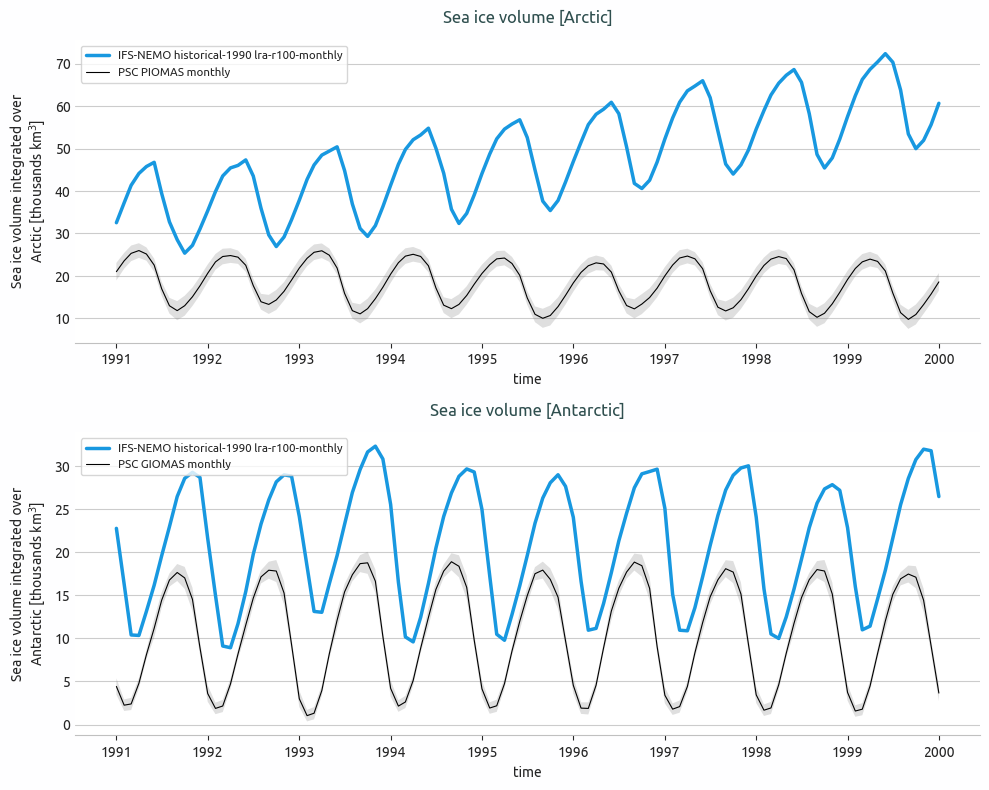

In [9]:
psi = PlotSeaIce(monthly_models=simod,
                 monthly_ref=[si_ref_nh, si_ref_sh],
                 monthly_std_ref=[si_std_ref_nh, si_std_ref_sh], 
                 outputdir='.',
                 rebuild=True,
                 loglevel=loglevel)
psi.plot_seaice(plot_type='timeseries', save_pdf=False, save_png=False)